# Tesla Stock Price Prediction, Test Bed
### Second Semester Capstone

In this notebook I'm experimenting with using fewer features, but also adding more lookback (i.e. instead of using features from point t-1, also include t-2, t-3, etc). So far I've received about 7.1% error using just the Google Trends data and a lookback of 5 (going back to point t-5), and attempts with higher lookback, such as 10, increase the amount of error.

I've done additional experiments with having a further starting point for features, such as starting at t-7 rather than t-1. With this I've produced results with roughly around 13% error

In [13]:
import pandas as pd
import numpy as np
#tf.compat.v1.disable_v2_behavior()
from math import sqrt, floor
from matplotlib import pyplot
from statistics import mean
from sklearn.metrics import mean_squared_error

# LSTM Application

## Preparing Data

In [14]:
# Loading Preprocessed Data File
df = pd.read_csv(
    "../Data/preprocessed.csv",
    usecols=[
        'Date','Close','Tesla Trend',
        'Month','Day of the Month','Day of the Week',
        'Musk Tweet Count'
    ],
    parse_dates=['Date'],
    index_col=0
)
df.dropna(inplace=True)
#df = df.loc[(df.index >= '2016-01-01')]

print(df.shape)
df.head()

(2699, 6)


,Close,Musk Tweet Count,Tesla Trend,Month,Day of the Month,Day of the Week
Date,,,,,,
2010-07-01,4.392,0.0,7.00,7,1,3
2010-07-02,3.840,0.0,6.09,7,2,4
2010-07-06,3.222,0.0,2.10,7,6,1
2010-07-07,3.160,0.0,3.78,7,7,2
2010-07-08,3.492,0.0,5.60,7,8,3


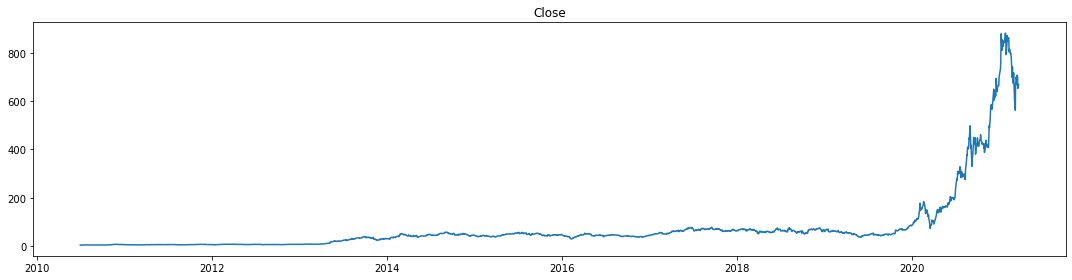

In [15]:
dates = df.index.to_numpy()
pyplot.figure(figsize=(15,4))

pyplot.plot(dates, df["Close"], label="Close")
pyplot.title("Close")

pyplot.tight_layout()
pyplot.show()

### Function For Converting Time Series Data For Supervised Learning

In [16]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, col_names, look_back=1, look_forward=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df_temp = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(look_back, 0, -1):
        cols.append(df_temp.shift(i))
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, look_forward):
        cols.append(df_temp.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col_names[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (col_names[j], i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Converting Data for Supervised Learning

In [17]:
from sklearn.preprocessing import MinMaxScaler

values = df.values
# integer encoding of labels (not using yet here since we don't have non-numerical data)
#encoder = LabelEncoder()
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, df.columns, look_back=1, look_forward=1)

# Drop Columns of Variables We Aren't Predicting
# We want only the variable we're predicting for time t
#reframed.drop(reframed.loc[:, 'Close(t-6)':'Day of the Week(t-1)'], axis=1, inplace=True)
reframed.drop(reframed.loc[:, 'Musk Tweet Count(t)':], axis=1, inplace=True)

print(reframed.shape)
reframed.head()

(2698, 7)


,Close(t-1),Musk Tweet Count(t-1),Tesla Trend(t-1),Month(t-1),Day of the Month(t-1),Day of the Week(t-1),Close(t)
1,0.001400,0.0,0.060606,0.545455,0.000000,0.75,0.000773
2,0.000773,0.0,0.051414,0.545455,0.033333,1.00,0.000070
3,0.000070,0.0,0.011111,0.545455,0.166667,0.25,0.000000
4,0.000000,0.0,0.028081,0.545455,0.200000,0.50,0.000377
5,0.000377,0.0,0.046465,0.545455,0.233333,0.75,0.000364


In [18]:
values = reframed.values
# split into train, test, and prediction sets
n_predict = 365 # We are predicting 365 days
n_train = floor((len(values)-n_predict) * 0.70) # 80% of the data is currently used for train (can be adjusted)
train = values[:n_train, :]
test = values[n_train:len(values)-n_predict, :] # What's left is used for test
predict = values[len(values)-n_predict:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
predict_X_2D, predict_y = predict[:, :-1], predict[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
predict_X = predict_X_2D.reshape((predict_X_2D.shape[0], 1, predict_X_2D.shape[1]))
predict_y_2D = predict_y.reshape((len(predict_y), 1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, predict_X.shape, predict_y.shape)

(1633, 1, 6) (1633,) (700, 1, 6) (700,) (365, 1, 6) (365,)


## Running Model

In [19]:
# Import keras libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.constraints import NonNeg

In [20]:
# Design Network
def fit_lstm(train_X, train_y, test_X, test_y, batch_size, n_epochs, n_neurons, dropout):
    model = Sequential()
    model.add(LSTM(n_neurons, return_sequences=False, input_shape=(train_X.shape[1], train_X.shape[2]), dropout=dropout))
    model.add(Dense(1, activation="linear", kernel_constraint=NonNeg()))

    model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

    # fit network
    history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    return model, history

Batch Size = 60
Trial 1 Normalized RMSE: 0.626 | Trial 2 Normalized RMSE: 0.629 | Trial 3 Normalized RMSE: 0.568 | Trial 4 Normalized RMSE: 0.510 | Trial 5 Normalized RMSE: 0.367 | 


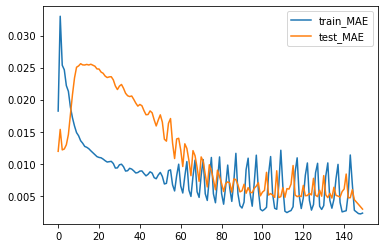

Best NRMSE: 0.367

Batch Size = 100
Trial 1 Normalized RMSE: 0.149 | Trial 2 Normalized RMSE: 0.100 | Trial 3 Normalized RMSE: 0.104 | Trial 4 Normalized RMSE: 0.158 | Trial 5 Normalized RMSE: 0.157 | 


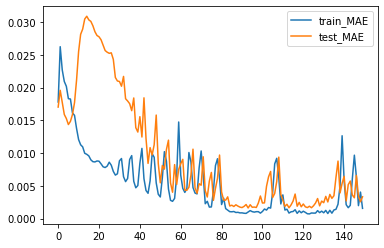

Best NRMSE: 0.100

Batch Size = 150
Trial 1 Normalized RMSE: 0.165 | Trial 2 Normalized RMSE: 0.062 | Trial 3 Normalized RMSE: 0.057 | Trial 4 Normalized RMSE: 0.058 | Trial 5 Normalized RMSE: 0.057 | 


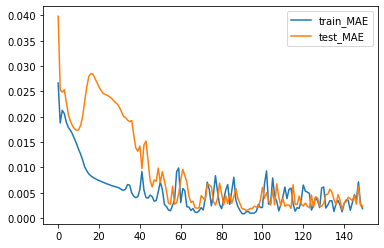

Best NRMSE: 0.057

Batch Size = 200
Trial 1 Normalized RMSE: 0.064 | Trial 2 Normalized RMSE: 0.059 | Trial 3 Normalized RMSE: 0.086 | Trial 4 Normalized RMSE: 0.098 | Trial 5 Normalized RMSE: 0.077 | 


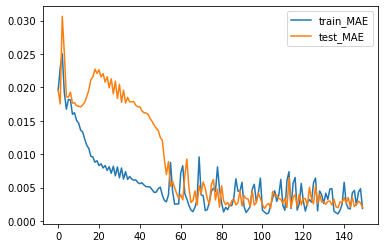

Best NRMSE: 0.059

Batch Size = 250
Trial 1 Normalized RMSE: 0.082 | Trial 2 Normalized RMSE: 0.059 | Trial 3 Normalized RMSE: 0.072 | Trial 4 Normalized RMSE: 0.059 | Trial 5 Normalized RMSE: 0.057 | 


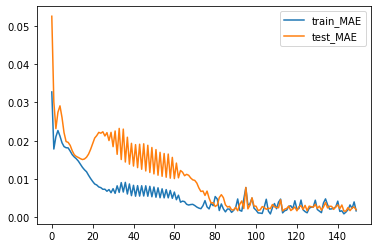

Best NRMSE: 0.057

Batch Size = 300
Trial 1 Normalized RMSE: 0.088 | Trial 2 Normalized RMSE: 0.060 | Trial 3 Normalized RMSE: 0.059 | Trial 4 Normalized RMSE: 0.061 | Trial 5 Normalized RMSE: 0.070 | 


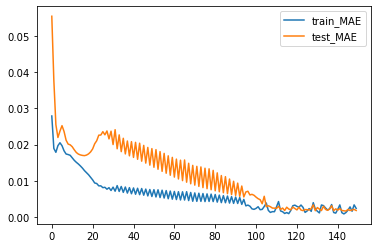

Best NRMSE: 0.059

Batch Size = 350
Trial 1 Normalized RMSE: 0.064 | Trial 2 Normalized RMSE: 0.060 | Trial 3 Normalized RMSE: 0.063 | Trial 4 Normalized RMSE: 0.061 | Trial 5 Normalized RMSE: 0.098 | 


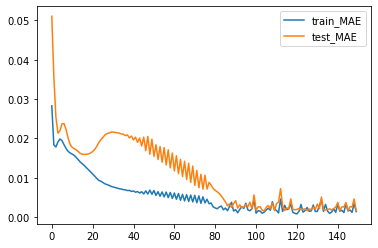

Best NRMSE: 0.060

Batch Size = 400
Trial 1 Normalized RMSE: 0.111 | Trial 2 Normalized RMSE: 0.131 | Trial 3 Normalized RMSE: 0.066 | Trial 4 Normalized RMSE: 0.120 | Trial 5 Normalized RMSE: 0.063 | 


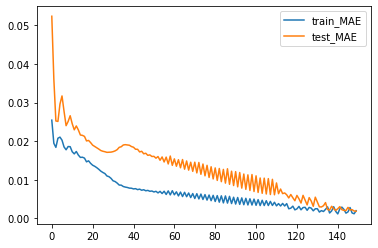

Best NRMSE: 0.063

Batch Size = 450
Trial 1 Normalized RMSE: 0.084 | Trial 2 Normalized RMSE: 0.063 | Trial 3 Normalized RMSE: 0.073 | Trial 4 Normalized RMSE: 0.071 | Trial 5 Normalized RMSE: 0.064 | 


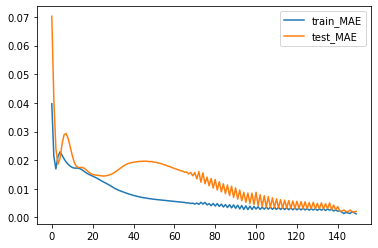

Best NRMSE: 0.063

Batch Size = 500
Trial 1 Normalized RMSE: 0.064 | Trial 2 Normalized RMSE: 0.086 | Trial 3 Normalized RMSE: 0.079 | Trial 4 Normalized RMSE: 0.078 | Trial 5 Normalized RMSE: 0.080 | 


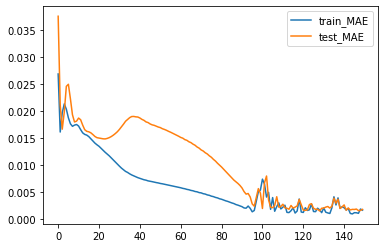

Best NRMSE: 0.064

Batch Size = 600
Trial 1 Normalized RMSE: 0.064 | Trial 2 Normalized RMSE: 0.066 | Trial 3 Normalized RMSE: 0.065 | Trial 4 Normalized RMSE: 0.066 | Trial 5 Normalized RMSE: 0.064 | 


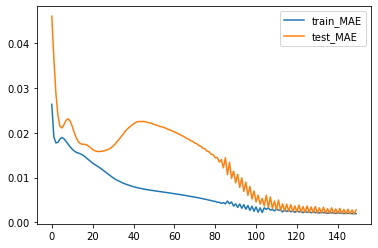

Best NRMSE: 0.064

Batch Size = 700
Trial 1 Normalized RMSE: 0.066 | Trial 2 Normalized RMSE: 0.066 | Trial 3 Normalized RMSE: 0.063 | Trial 4 Normalized RMSE: 0.068 | Trial 5 Normalized RMSE: 0.065 | 


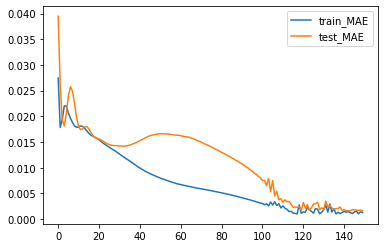

Best NRMSE: 0.063

Batch Size = 800
Trial 1 Normalized RMSE: 0.158 | Trial 2 Normalized RMSE: 0.174 | Trial 3 Normalized RMSE: 0.227 | Trial 4 Normalized RMSE: 0.122 | Trial 5 Normalized RMSE: 0.143 | 


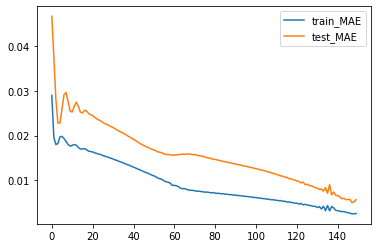

Best NRMSE: 0.122



In [21]:
n_trials = 5
n_epochs = 150
batch_size = [60, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800]
n_neurons = 200
dropout = 0.0

results = {}
results["best_nrmse"] = {}
results["best_history"] = {}
results["best_invy"] = {}
results["best_invyhat"] = {}

for testingThing in batch_size:
    if testingThing not in results["best_nrmse"]:
        results["best_nrmse"][testingThing] = 1000
    print("Batch Size = %s" %(testingThing))
    for r in range(n_trials):
        print("Trial %i " %(r+1), end="")
        model, history = fit_lstm(train_X, train_y, test_X, test_y, testingThing, n_epochs, n_neurons, dropout)
        # make a prediction
        yhat = model.predict(predict_X)

        # invert scaling for forecast
        inv_yhat = np.concatenate((yhat, predict_X_2D[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        inv_y = np.concatenate((predict_y_2D, predict_X_2D[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        #print('Test RMSE: %.3f' % rmse)
        normalized_rmse = rmse/(mean(inv_y))
        print('Normalized RMSE: %.3f | ' % normalized_rmse, end="")
        if normalized_rmse < results["best_nrmse"][testingThing]:
            results["best_nrmse"][testingThing] = normalized_rmse
            results["best_history"][testingThing] = history
            results["best_invy"][testingThing] = inv_y
            results["best_invyhat"][testingThing] = inv_yhat
    print()
    pyplot.figure()
    pyplot.plot(results["best_history"][testingThing].history['loss'], label='train_MAE')
    pyplot.plot(results["best_history"][testingThing].history['val_loss'], label='test_MAE')
    pyplot.legend()
    pyplot.show()
    print("Best NRMSE: %.3f\n" %(results["best_nrmse"][testingThing]))

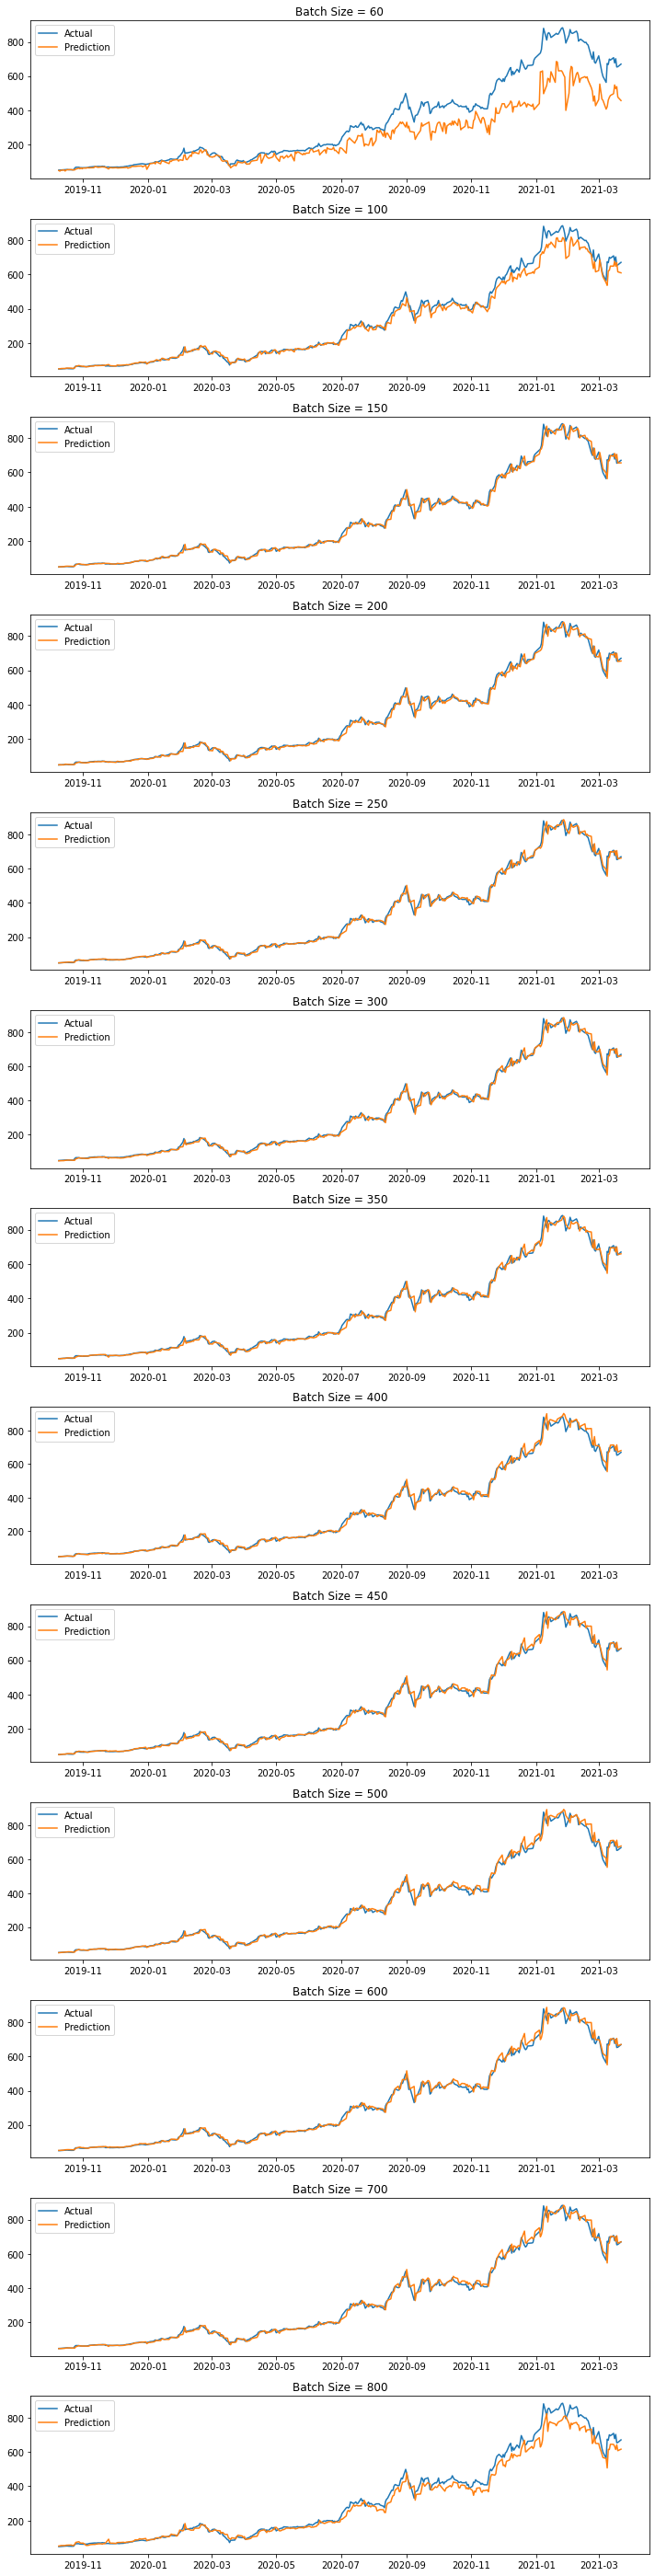

In [25]:
predictDates = dates[len(dates)-n_predict:]
pyplot.figure(figsize=(10,3*len(batch_size)))
i = 1
for testingThing in batch_size:
    inv_y = results["best_invy"][testingThing]
    inv_yhat = results["best_invyhat"][testingThing]

    pyplot.subplot(len(batch_size), 1, i)
    pyplot.plot(predictDates, inv_y, label="Actual")
    pyplot.plot(predictDates, inv_yhat, label="Prediction")
    pyplot.legend(loc='upper left')
    pyplot.title("Batch Size = %s" %(testingThing))

    i+= 1

pyplot.tight_layout()
pyplot.show()
    